In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib"
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.7 MB/s eta 0:00:00


In [2]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.dev2427
Numpy version: 1.25.2
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cbf90d0ddb27dc96a91385e4dd2f4eb239dea976
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.41.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visi

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpp7_0tx0h


In [4]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:00, 64.0MB/s]                            

2024-07-07 06:47:39,575 - INFO - Downloaded: /tmp/tmpp7_0tx0h/MedNIST.tar.gz


2024-07-07 06:47:39,700 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-07-07 06:47:39,702 - INFO - Writing into directory: /tmp/tmpp7_0tx0h.


In [5]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


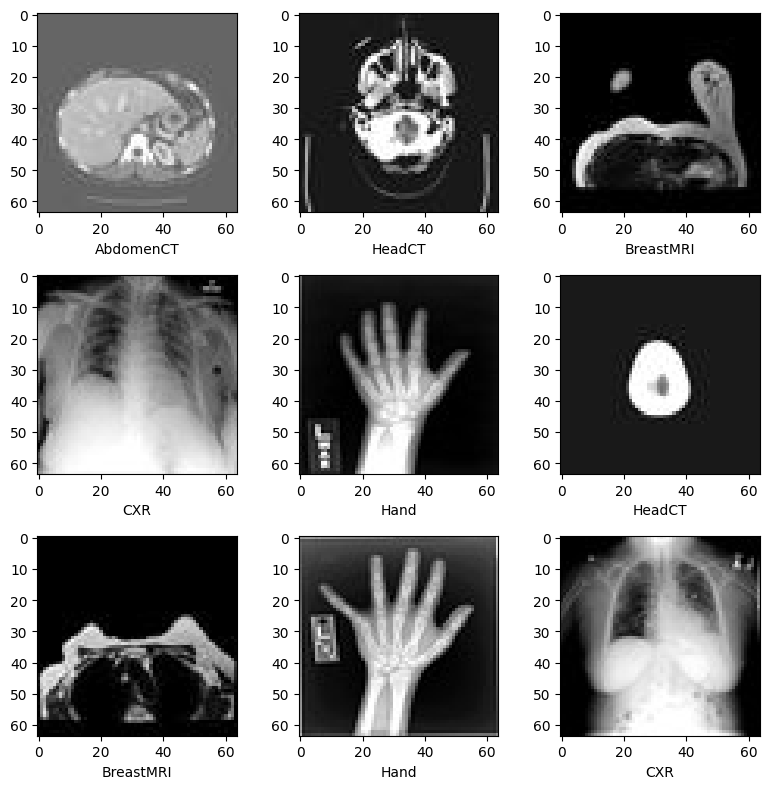

In [6]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [7]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


In [8]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [9]:

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

In [11]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/4


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/157, train_loss: 1.8533
2/157, train_loss: 1.8419
3/157, train_loss: 1.7811
4/157, train_loss: 1.7844
5/157, train_loss: 1.7452
6/157, train_loss: 1.7047
7/157, train_loss: 1.7045
8/157, train_loss: 1.6779
9/157, train_loss: 1.6381
10/157, train_loss: 1.6096
11/157, train_loss: 1.6014
12/157, train_loss: 1.5678
13/157, train_loss: 1.5707
14/157, train_loss: 1.5586
15/157, train_loss: 1.4896
16/157, train_loss: 1.4999
17/157, train_loss: 1.4623
18/157, train_loss: 1.4285
19/157, train_loss: 1.4301
20/157, train_loss: 1.3765
21/157, train_loss: 1.3873
22/157, train_loss: 1.3636
23/157, train_loss: 1.3134
24/157, train_loss: 1.3220
25/157, train_loss: 1.3096
26/157, train_loss: 1.2762
27/157, train_loss: 1.2971
28/157, train_loss: 1.2465
29/157, train_loss: 1.2493
30/157, train_loss: 1.2296
31/157, train_loss: 1.1920
32/157, train_loss: 1.1930
33/157, train_loss: 1.1925
34/157, train_loss: 1.1424
35/157, train_loss: 1.1148
36/157, train_loss: 1.1320
37/157, train_loss: 1.0999
38/157, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


158/157, train_loss: 0.3063
epoch 1 average loss: 0.7653
saved new best metric model
current epoch: 1 current AUC: 0.9984 current accuracy: 0.9620 best AUC: 0.9984 at epoch: 1
----------
epoch 2/4
1/157, train_loss: 0.2478
2/157, train_loss: 0.2356
3/157, train_loss: 0.2868
4/157, train_loss: 0.2148
5/157, train_loss: 0.2477
6/157, train_loss: 0.2360
7/157, train_loss: 0.2559
8/157, train_loss: 0.2446
9/157, train_loss: 0.2398
10/157, train_loss: 0.2780
11/157, train_loss: 0.2567
12/157, train_loss: 0.2442
13/157, train_loss: 0.2367
14/157, train_loss: 0.2264
15/157, train_loss: 0.2276
16/157, train_loss: 0.2210
17/157, train_loss: 0.2135
18/157, train_loss: 0.2137
19/157, train_loss: 0.2190
20/157, train_loss: 0.2055
21/157, train_loss: 0.1849
22/157, train_loss: 0.2403
23/157, train_loss: 0.2213
24/157, train_loss: 0.1976
25/157, train_loss: 0.1940
26/157, train_loss: 0.2305
27/157, train_loss: 0.2035
28/157, train_loss: 0.1958
29/157, train_loss: 0.1836
30/157, train_loss: 0.1883
31

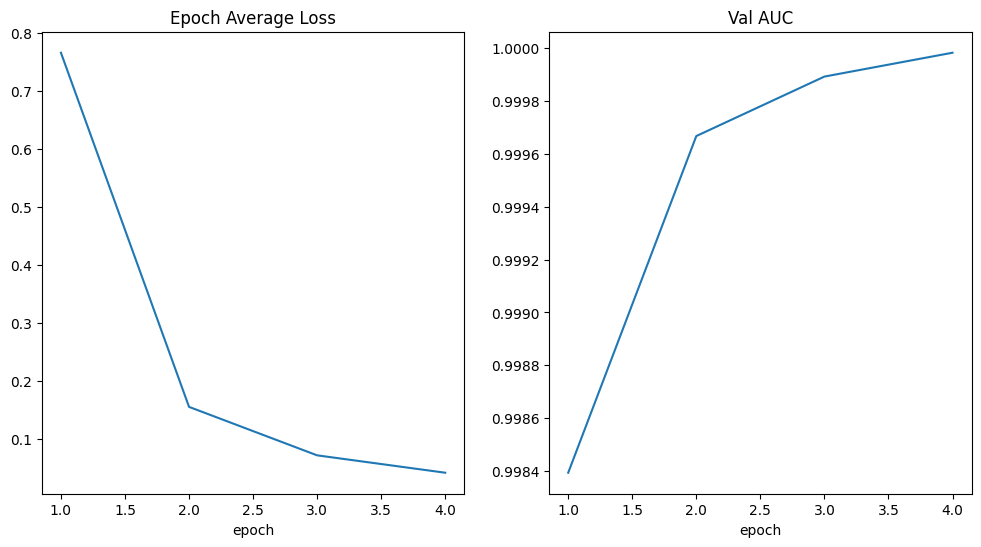

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [13]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [14]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9918    0.9918    0.9918       979
   BreastMRI     0.9967    0.9945    0.9956       903
         CXR     0.9980    0.9949    0.9964       979
     ChestCT     0.9932    1.0000    0.9966      1015
        Hand     0.9970    0.9950    0.9960       994
      HeadCT     0.9951    0.9951    0.9951      1025

    accuracy                         0.9953      5895
   macro avg     0.9953    0.9952    0.9952      5895
weighted avg     0.9953    0.9953    0.9952      5895

